In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from torch.utils.data import  DataLoader
import datetime
import pickle

In [2]:
from utils.common_utils import fraud_classes_mapping

In [3]:
import torch
from torch import nn
from tqdm import tqdm
import os

In [4]:
columns1 = list(map(lambda x: x.lower().replace('_',' '),["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","target",'ne_ponytno']))
columns2 = list(map(lambda x: x.lower().replace('_',' '), """Duration
Service
Source bytes
Destination bytes
Count
Same srv rate
Serror rate
Srv serror rate
Dst host count
Dst host srv count
Dst host same src port rate
Dst host serror rate
Dst host srv serror rate
Flag
IDS detection
Malware detection
Ashula detection
Label
Source IP Address
Source Port Number
Destination IP Address
Destination Port Number
Start Time
Duration1""".split('\n')))

In [5]:
columns2

['duration',
 'service',
 'source bytes',
 'destination bytes',
 'count',
 'same srv rate',
 'serror rate',
 'srv serror rate',
 'dst host count',
 'dst host srv count',
 'dst host same src port rate',
 'dst host serror rate',
 'dst host srv serror rate',
 'flag',
 'ids detection',
 'malware detection',
 'ashula detection',
 'label',
 'source ip address',
 'source port number',
 'destination ip address',
 'destination port number',
 'start time',
 'duration1']

In [6]:
common = list(set(columns1) & set(columns2))
common

['service',
 'same srv rate',
 'srv serror rate',
 'dst host same src port rate',
 'dst host serror rate',
 'dst host srv count',
 'duration',
 'dst host count',
 'serror rate',
 'dst host srv serror rate',
 'flag',
 'count']

In [23]:
train = pd.read_csv('../data/KDD/KDDTrain+.txt', names=columns1)
test = pd.read_csv('../data/KDD/KDDTest+.txt', names=columns1)

In [24]:
y_tr = fraud_classes_mapping(train.target)
y_test = fraud_classes_mapping(test.target)
df = pd.concat([train,test],ignore_index=True)
y_df = fraud_classes_mapping(df.target)

<AxesSubplot:>

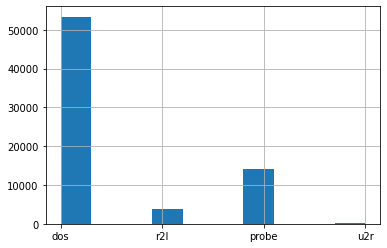

In [25]:
y_df[y_df!='norm'].hist()

In [26]:
train = train[common]
test = test[common]
df = df[common]

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [28]:
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = LabelEncoder().fit_transform(df[i])

In [29]:
le_y = LabelEncoder()
le_y.fit(y_df)
with open('target_encoder.pcl', 'wb') as fd:
    pickle.dump(le_y, fd)

In [30]:
X_train, X_test, y_train, y_test = df[:len(train)], df[len(train):],le_y.transform(y_tr) , le_y.transform(y_test)

In [31]:
rfc = RandomForestClassifier(n_jobs=-1)

In [46]:
import xgboost as xgb
rfc = xgb.XGBClassifier(max_depth=20,n_estimators=1000,min_child_weight=100)

In [47]:
rfc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
y = rfc.predict(X_train)

In [49]:
print(f"Точность на тестовой выборке: {accuracy_score(rfc.predict(df[len(train):]), y_test):.4f}")
start = datetime.datetime.now()
rfc.predict(df[len(train):])
end = datetime.datetime.now()
print(f'Время выполнения расчета для {len(y_test)} строк логов (тестовая выборка):\n{end-start}')

Точность на тестовой выборке: 0.7333
Время выполнения расчета для 22544 строк логов (тестовая выборка):
0:00:00.803484


In [45]:
%%timeit
rfc.predict(df[len(train):])

192 ms ± 665 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Kyoto

In [50]:
path = '../data/Kyoto2016/'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))
files[:4]

['../data/Kyoto2016/2015/01/20150122.txt',
 '../data/Kyoto2016/2015/01/20150131.txt',
 '../data/Kyoto2016/2015/01/20150130.txt',
 '../data/Kyoto2016/2015/01/20150113.txt']

In [51]:
common = ['same srv rate',
 'service',
 'serror rate',
 'flag',
 'dst host same src port rate',
 'srv serror rate',
 'dst host srv serror rate',
 'dst host srv count',
 'count',
 'duration',
 'dst host serror rate',
 'dst host count']

In [52]:
train = pd.read_csv(files[0],sep='\t',names=columns2)
print(len(train))
for f in np.random.choice(files[1:],1):    
    train = train.append(pd.read_csv(f,sep='\t',names=columns2),ignore_index=True)
    print(len(train))
for i in train.columns:
    if train[i].dtype == 'object':
        encoder = LabelEncoder().fit(train[i])
        with open(f'{i}.pcl', 'wb') as fd:
            pickle.dump(encoder, fd)
        train[i] = encoder.transform(train[i])
y = rfc.predict(train[common])

633250


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


996093


TypeError: Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']

In [48]:
train['predictions'] = le_y.inverse_transform(y)

In [64]:
train[['predictions', 'start time']].pivot(index='start time', columns='predictions')

ValueError: Index contains duplicate entries, cannot reshape

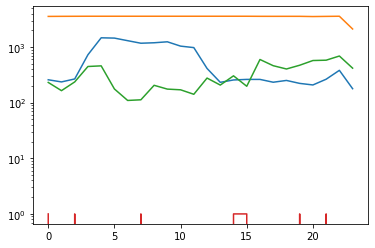

In [128]:
a = train[['predictions', 'start time']].groupby(['start time', 'predictions'])['predictions'].count()
a = a.reset_index(name=('count'))
a = a.pivot_table(values='count', index='start time', columns='predictions',)
def to_time(t):
    h = t//3600
    m = (t - h*3600)//60
    s = t - h*3600 - m*60
    return datetime.datetime(2000,1,1,h,m,s)
a.index = a.reset_index()['start time'].apply(lambda x: to_time(x))
a = a.groupby(a.index.hour).count()
plt.semilogy((a))

In [135]:
a.reset_index()['start time'].apply(lambda x: to_time(x))

TypeError: 'int' object is not subscriptable

In [129]:
a = train[['predictions', 'start time']].groupby(['start time', 'predictions'])['predictions'].count()
a = a.reset_index(name=('count'))
a = a.pivot_table(values='count', index='start time', columns='predictions',)
def to_time(t):
    h = int(t[0:2])
    m = int(t[3:5])
    s = int(t[6:8])
    return datetime.datetime(2000,1,1,h,m,s)
a.index = a.reset_index()['start time'].apply(lambda x: to_time(x))
a = a.groupby(a.index.hour).count()



TypeError: 'int' object is not subscriptable

In [88]:
import datetime

In [117]:
t = 40121
h = t//3600
m = (t - h*3600)//60
s = t - h*3600 - m*60
print(datetime.time(h,m,s))

11:08:41


In [104]:
datetime.time(40001//(3600), (40000-60*40000//(60))//60)

ValueError: minute must be in 0..59

In [124]:
# Using plotly.express
import plotly.express as px

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = px.line(df, x='Date', y='AAPL.High', range_x=['2016-07-01','2016-12-31'])
fig.show()

In [112]:
3600*24

86400

In [56]:
train[['start time','predictions']].groupby(['start time','predictions']).count()

,
start time,predictions
0,norm
1,probe
2,norm
3,norm
4,norm
...,...
84919,norm
84920,norm
84921,norm


In [114]:
len(train)

6432379

In [115]:
np.unique(y,return_counts=True)

(array([0, 1, 2, 3]), array([   2832, 6154351,  275194,       2]))

In [49]:
import pickle

with open('Dict.pickle', 'wb') as handle:
    pickle.dump(Dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('Dict.pickle', 'rb') as handle:
    Dict = pickle.load(handle)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
with open('model.pickle', 'wb') as fd:
        pickle.dump(rfc, fd, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
def predict(df):
    common = ['same srv rate',
             'service',
             'serror rate',
             'flag',
             'dst host same src port rate',
             'srv serror rate',
             'dst host srv serror rate',
             'dst host srv count',
             'count',
             'duration',
             'dst host serror rate',
             'dst host count']
    with open('model.pickle', 'rb') as fd:
        rfc = pickle.load(fd, protocol=pickle.HIGHEST_PROTOCOL)


    X = df[common]
    y = rfc.predict(X)
    return y
    

In [61]:
import pickle


with open('predict.pickle', 'wb') as fd:
    pickle.dump(predict, fd, protocol=pickle.HIGHEST_PROTOCOL)



In [118]:
cols = ['Duration', 'Service', 'Source bytes', 'Destination bytes', 'Count',
       'Same srv rate', 'Serror rate', 'Srv serror rate', 'Dst host count',
       'Dst host srv count', 'Dst host same src port rate',
       'Dst host serror rate', 'Dst host srv serror rate', 'Flag',
       'IDS detection', 'Malware detection', 'Ashula detection', 'Label',
       'Source IP Address', 'Source Port Number', 'Destination IP Address',
       'Destination Port Number', 'Start Time', 'Protocol']


In [119]:
[w.lower() for w in cols]

['duration',
 'service',
 'source bytes',
 'destination bytes',
 'count',
 'same srv rate',
 'serror rate',
 'srv serror rate',
 'dst host count',
 'dst host srv count',
 'dst host same src port rate',
 'dst host serror rate',
 'dst host srv serror rate',
 'flag',
 'ids detection',
 'malware detection',
 'ashula detection',
 'label',
 'source ip address',
 'source port number',
 'destination ip address',
 'destination port number',
 'start time',
 'protocol']